In [1]:
# pip install imbalanced-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, fbeta_score, precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer

In [3]:
#Reading the final Data - feature engineered
data = pd.read_csv("engineered_data.csv")
data = data.drop(columns=['Unnamed: 0'])

In [4]:
data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,year_acitv,year_end,year_modif,year_renewal,comb_effect
0,24011ae4ebbe3035111d65fa7c15bc57,4,0.000000,4.739944,0.000000,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.000000,...,4,43.648,1,0.020057,3.700961,2013,2016,2015,2015,0.000000
1,d29c2c54acc38ff3c0614d0a653813dd,0,3.668479,0.000000,0.000000,2009-08-21,2016-08-30,2009-08-21,2015-08-31,2.280920,...,2,13.800,0,-0.003767,0.177779,2009,2016,2009,2015,-1.462852
2,764c75f661154dac3a6c254cd082ea7d,4,2.736397,0.000000,0.000000,2010-04-16,2016-04-16,2010-04-16,2015-04-17,1.689841,...,2,13.856,0,-0.004670,0.177779,2010,2016,2010,2015,-0.211707
3,bba03439a292a1e166f80264c16191cb,5,3.200029,0.000000,0.000000,2010-03-30,2016-03-30,2010-03-30,2015-03-31,2.382089,...,2,13.200,0,-0.004547,0.177779,2010,2016,2010,2015,-0.600204
4,149d57cf92fc41cf94415803a877cb4b,0,3.646011,0.000000,2.721811,2010-01-13,2016-03-07,2010-01-13,2015-03-09,2.650065,...,2,19.800,0,-0.006192,0.162916,2010,2016,2010,2015,0.973692


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               14606 non-null  object 
 1   channel_sales                    14606 non-null  int64  
 2   cons_12m                         14606 non-null  float64
 3   cons_gas_12m                     14606 non-null  float64
 4   cons_last_month                  14606 non-null  float64
 5   date_activ                       14606 non-null  object 
 6   date_end                         14606 non-null  object 
 7   date_modif_prod                  14606 non-null  object 
 8   date_renewal                     14606 non-null  object 
 9   forecast_cons_12m                14606 non-null  float64
 10  forecast_cons_year               14606 non-null  float64
 11  forecast_discount_energy         14606 non-null  float64
 12  forecast_meter_ren

In [6]:
# data['date_activ'] = pd.to_datetime(data['date_activ'], format = '%Y-%m-%d')
# data["date_end"] = pd.to_datetime(data["date_end"], format='%Y-%m-%d')
# data["date_modif_prod"] = pd.to_datetime(data["date_modif_prod"], format='%Y-%m-%d')
# data["date_renewal"] = pd.to_datetime(data["date_renewal"], format='%Y-%m-%d')
data.drop(columns=['date_activ',"date_end","date_modif_prod","date_renewal"], inplace = True)

In [7]:
X = data.drop(columns=['churn','id'])
y=data['churn']

#Rectifying the imbalance using SMOTE technique
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101, stratify=y)

In [9]:
%%time
#Creating a random forest calssifier
clf = RandomForestClassifier(random_state=101, n_jobs=-1, max_depth=None, n_estimators=300, oob_score=True)
clf.fit(X_train, y_train)
#out of bag score
clf.oob_score_

CPU times: total: 41.8 s
Wall time: 8.06 s


0.9463734358918802

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3956
           1       0.97      0.92      0.95      3957

    accuracy                           0.95      7913
   macro avg       0.95      0.95      0.95      7913
weighted avg       0.95      0.95      0.95      7913



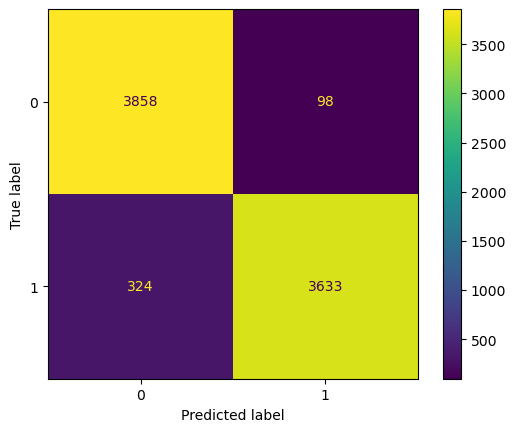

In [10]:
#Predicting the text dataset
y_pred = clf.predict(X_test)

#visualising the confusion matric display
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_test,y_pred))

In [11]:
# pip install graphviz

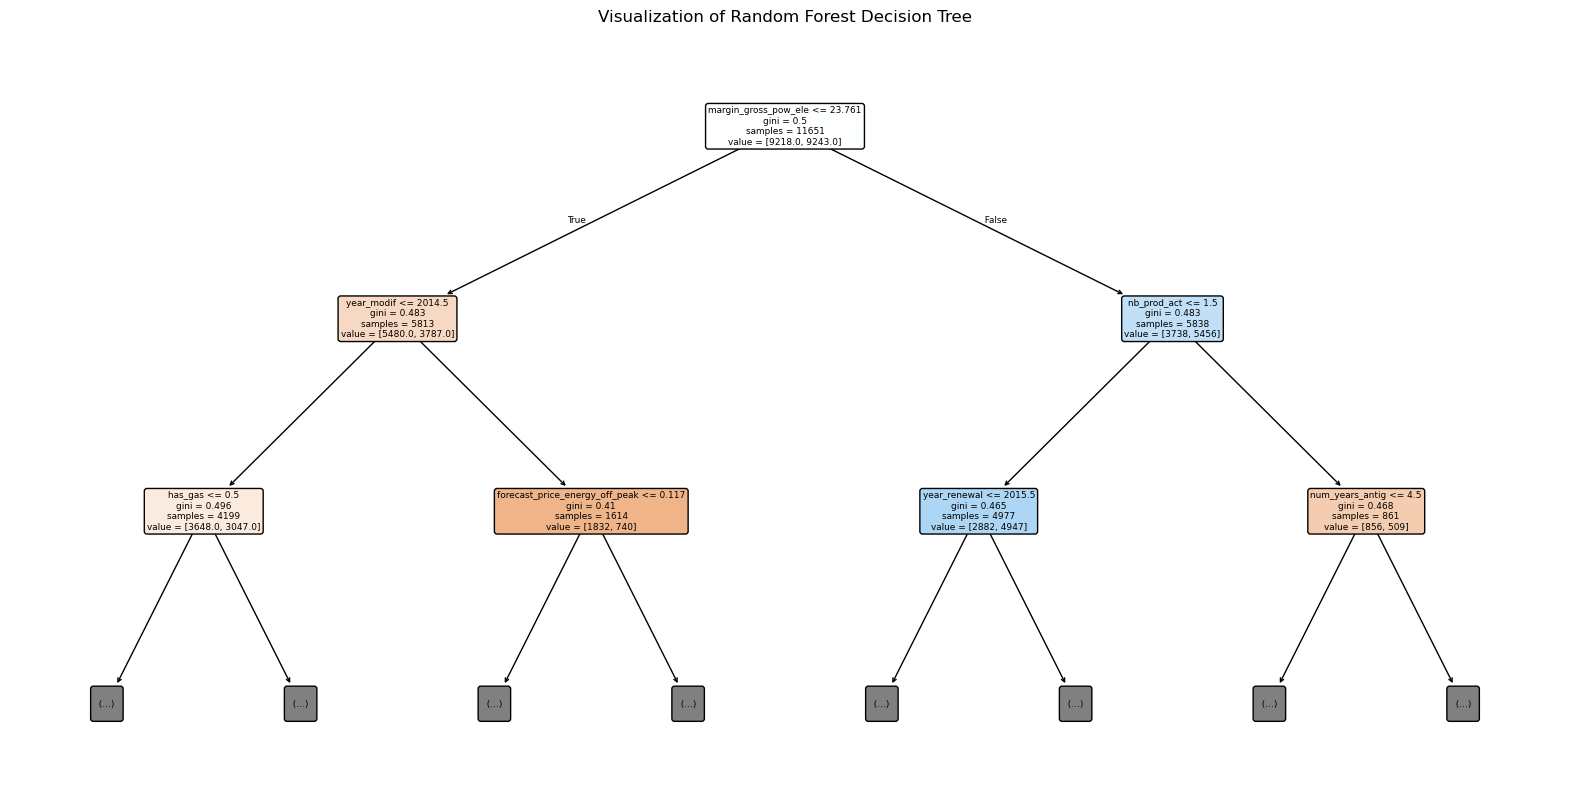

In [12]:
from sklearn.tree import plot_tree
# Extract one tree from the Random Forest (e.g., the first tree)
tree = clf.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_train.columns, filled=True, rounded=True, max_depth=2)
plt.title("Visualization of Random Forest Decision Tree")
plt.show()

In [13]:
#calculating the f2_score using the f-beta score
print(fbeta_score(y_test, y_pred, beta=2.0))

0.9287284626003375


In [14]:
#Cross validation 
# scores = cross_val_score(clf, X, y, cv=10)
# print(scores)

In [15]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # Defining a customer scorer evaluation for the cross_val_score
# def f2_scorer(y_true, y_pred):
#     return fbeta_score(y_true, y_pred, beta=2)

# # Make scorer object using the custom scorer
# f2_scorer_obj = make_scorer(f2_scorer)

# scores = cross_val_score(clf, X, y, cv=cv, n_jobs=-1,scoring=f2_scorer_obj)


In [16]:
# print("Scores across all folds\n:",scores)
# print("Average score across all folds: ",scores.mean())

In [17]:
importances = clf.feature_importances_
feature_names = clf.feature_names_in_
forest_importance = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

Text(0, 0.5, 'Mean decrease in impurity')

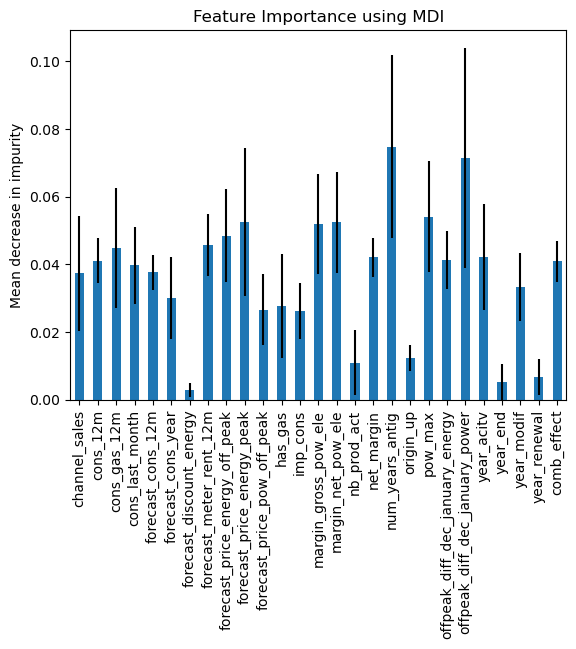

In [18]:
fig,ax = plt.subplots()
forest_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance using MDI")
ax.set_ylabel("Mean decrease in impurity")

# Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

modelDT = DecisionTreeClassifier(random_state = 101, max_depth = 5)
modelDT.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=5, random_state=101)

In [20]:
y_pred = modelDT.predict(X_test)

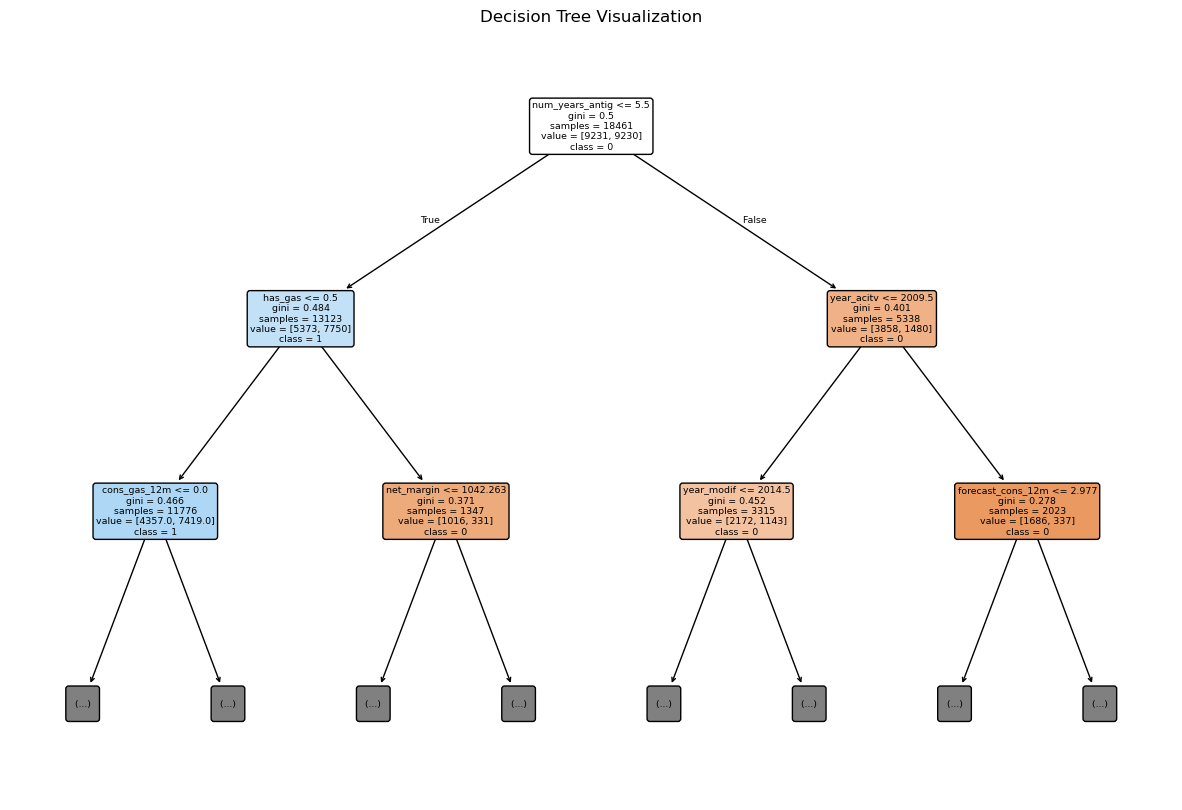

In [21]:
plt.figure(figsize=(15, 10))  # Adjust the figure size to fit the tree
plot_tree(modelDT, feature_names=X_train.columns, class_names=[str(i) for i in np.unique(y_train)], 
          filled=True, rounded=True, max_depth=2)  # Visualizing only up to depth 3 for clarity
plt.title("Decision Tree Visualization")
plt.show()

In [22]:
accuracy = accuracy_score( y_test, y_pred)
precision = precision_score( y_test,y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')

In [23]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.70
Precision: 0.71
Recall: 0.70
F1 score: 0.70


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      3956
           1       0.74      0.63      0.68      3957

    accuracy                           0.70      7913
   macro avg       0.71      0.70      0.70      7913
weighted avg       0.71      0.70      0.70      7913



# SVM Classification

In [25]:
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

modelSVM = SVC(kernel = 'linear', random_state = 101)
modelSVM.fit(X_train_scaled, y_train)


SVC(kernel='linear', random_state=101)

In [26]:
y_pred = modelSVM.predict(X_test_scaled)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F1 Score: 0.79


In [28]:
X_train.nunique()

channel_sales                          8
cons_12m                           16246
cons_gas_12m                        3604
cons_last_month                    10313
forecast_cons_12m                  18061
forecast_cons_year                  9410
forecast_discount_energy             355
forecast_meter_rent_12m            11022
forecast_price_energy_off_peak      7873
forecast_price_energy_peak          5586
forecast_price_pow_off_peak         3363
has_gas                                2
imp_cons                           11521
margin_gross_pow_ele                9546
margin_net_pow_ele                  9546
nb_prod_act                            9
net_margin                         17048
num_years_antig                       13
origin_up                              6
pow_max                             7804
offpeak_diff_dec_january_energy     9265
offpeak_diff_dec_january_power      5360
year_acitv                            12
year_end                               2
year_modif      

In [29]:
from sklearn.decomposition import PCA

In [30]:
# Step 1: Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 2: Train the SVM Classifier on the 2D PCA data
modelSVMpca = SVC(kernel='linear', random_state=101)
modelSVMpca.fit(X_train_pca, y_train)



SVC(kernel='linear', random_state=101)

In [31]:
# Step 3: Predict on Test Data
y_pred = modelSVMpca.predict(X_test_pca)

# Step 4: Calculate Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.56
Precision: 0.56
Recall: 0.56
F1 Score: 0.56

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      3956
           1       0.56      0.57      0.56      3957

    accuracy                           0.56      7913
   macro avg       0.56      0.56      0.56      7913
weighted avg       0.56      0.56      0.56      7913



# ANN Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Step 3: Define the ANN Model
model = Sequential()

# Input layer
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layer 1
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Hidden layer 2
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer: Set the number of units to the number of classes for multi-class classification
# For binary classification, use 1 unit with 'sigmoid' activation
model.add(Dense(y_train, activation='softmax'))

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=50, batch_size=32)

TypeError: cannot convert the series to <class 'int'>

# KNN Classification

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # Example with 5 neighbors

# Step 3: Train the model
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [36]:
y_pred = knn.predict(X_test_scaled)

In [37]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # For multi-class use 'weighted'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1 Score: 0.87


In [38]:
# Optional: Find the best number of neighbors using cross-validation
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 21)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest number of neighbors: {grid_search.best_params_['n_neighbors']}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")


Best number of neighbors: 1
Best cross-validation score: 0.89


# Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

# Step 3: Train the model
nb.fit(X_train_scaled, y_train)

GaussianNB()

In [40]:
y_pred = nb.predict(X_test_scaled)

In [41]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # For multi-class use 'weighted'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.60
Precision: 0.64
Recall: 0.60
F1 Score: 0.57


In [42]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [43]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0)  # Adjust parameters as needed

# Step 3: Train the model
catboost_model.fit(X_train_scaled, y_train)

In [44]:
y_pred = catboost_model.predict(X_test_scaled)


In [45]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # For multi-class use 'weighted'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
